In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../PI_GP_regressor')

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_wave_3d import gram_Matrix,k_ff, k_fu, k_uf, k_uu

In [2]:
kernel_list = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
hyperparameters = ["l_space", "sigma", "l_t", "c"]
model = PhysicsInformedGP_regressor(kernel_list, params = hyperparameters,timedependence=True, Dimensions = 3)

n_training_points = 400

model.set_training_data("",n_training_points, noise = [1e-7,1e-7])

 /Users/tobileitgeb/Code/Code_bac/final_examples/wave_equation/../../PI_GP_regressor/main_class.py:957: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/wave_equation/../../PI_GP_regressor/main_class.py:968: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


In [3]:
model.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-4, -2, 1))  #lt
    theta_initial[3] = rng.uniform(1, 2, 1)               #c
    return theta_initial
n_restarts = 30
n_threads = 6
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, 1.5),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-6}
model.train("L-BFGS-B",n_restarts, n_threads,opt_params_dict)

100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


      fun: 1477.4561767578125
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 110
      nit: 3
     njev: 22
   status: 0
  success: True
        x: array([0.6251885 , 1.02918117, 0.07310459, 1.12618384])


In [20]:
model.log_marginal_likelohood([0.48876648, 0.49774337, 0.11136708, 1.13882743])

Array(1236.6282, dtype=float32)

In [5]:
grid_number = 101
x = np.linspace(0,2,grid_number).reshape(-1,1)
y = np.linspace(0,2,grid_number).reshape(-1,1)
t = np.linspace(0,4,grid_number).reshape(-1,1)
gx, gy = np.meshgrid(x,y)

X_2d = np.c_[gx.ravel(), gy.ravel()]
mean = []
var = []
time_points = np.linspace(0,4,81)
for i in range(len(time_points)):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = model.predict_u(X_3d)
    mean.append(mean_i)
    var.append(var_i)

In [6]:
#calculate the mean in parallel
from joblib import Parallel, delayed
def parallel_mean(i):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = model.predict_u(X_3d)
    return mean_i
mean = Parallel(n_jobs=6)(delayed(parallel_mean)(i) for i in range(len(time_points)))

(81, 101, 101)


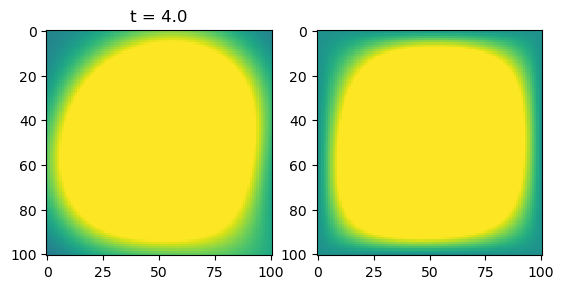

In [7]:
from matplotlib.animation import FuncAnimation
mean = np.array(mean)
mean = mean.reshape(len(time_points),grid_number,grid_number)
u_matrix = model.raw_data[2]
print(mean.shape)
fig, ax  = plt.subplots(1,2)
def frame(i):
    ax[0].clear()
    im = ax[0].imshow(mean[i,:,:].T, cmap='viridis', interpolation='nearest',vmin = -1.5, vmax = 1.5)
    ax[0].set_title('t = ' + str(time_points[i]))
    ax[1].clear()
    im = ax[1].imshow(u_matrix[:,:,i], cmap='viridis', interpolation='nearest',vmin = -1.5, vmax = 1.5)
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('test3.mp4', writer='ffmpeg', fps=10)



(101, 101, 81)


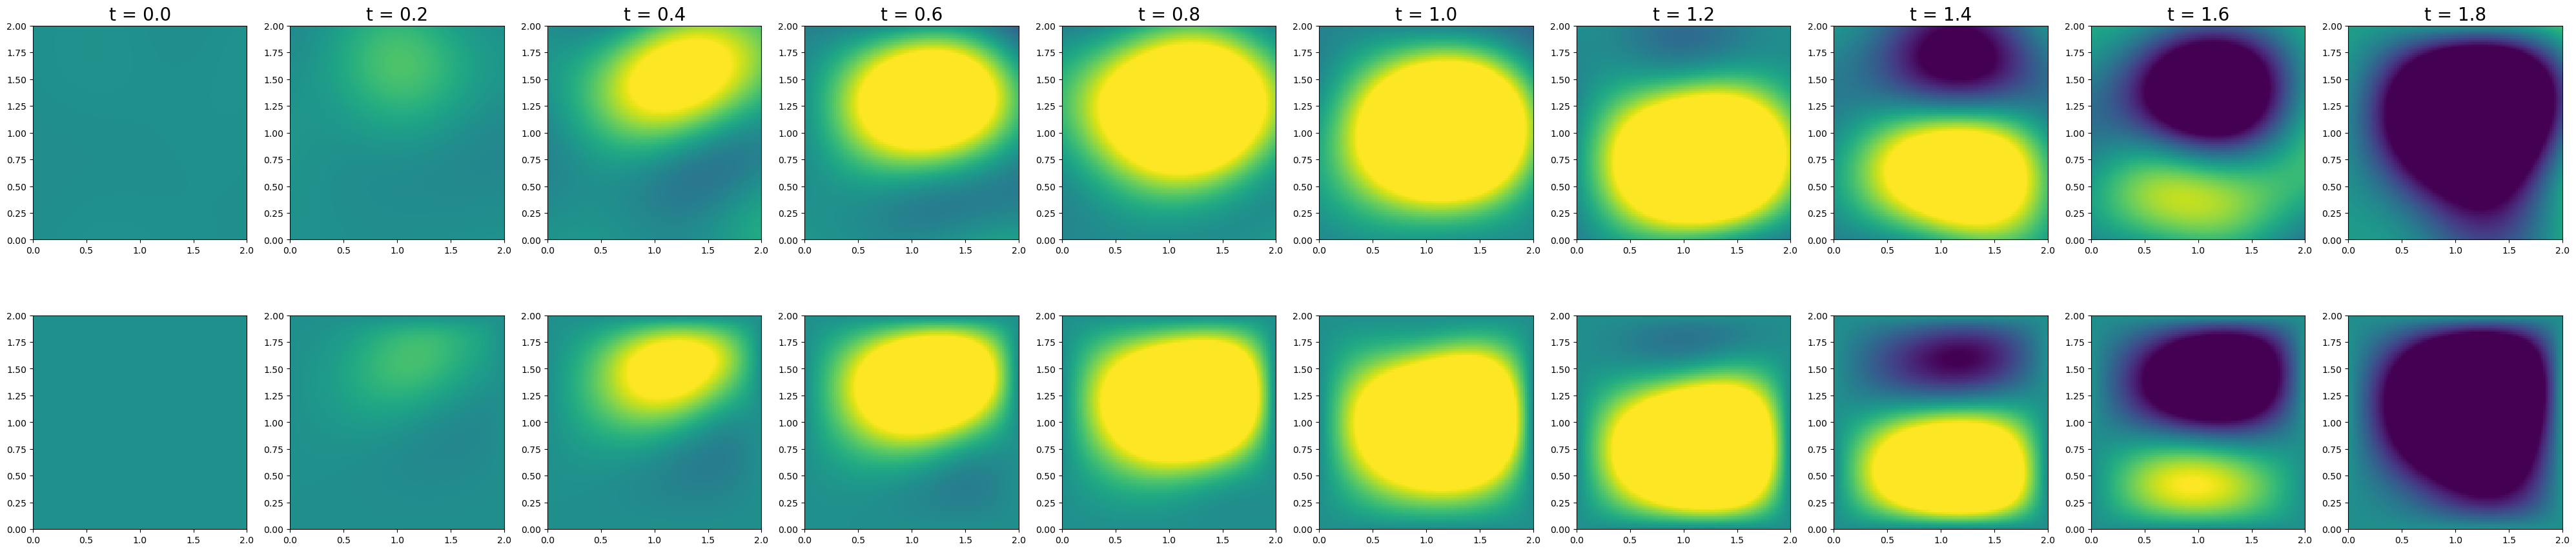

In [18]:
fig, ax = plt.subplots(2,10,figsize=(40,10))
ax = ax.flatten()
#split the ax
ax_1 = ax[:10]
ax_2 = ax[10:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(10),np.linspace(0, 4, len(u_matrix[0,0,:]))):
    
    im = ax_2[i].imshow(u_matrix[:,:,i*5].T, cmap='viridis',extent=[0,2,0,2],vmin = -1, vmax = 1)
    #plot the train points. we need to chekck for every t value and then plot the x,y coordinates
    #ax[i].scatter(x_train_u[t_train_u==i*5], y_train_u[t_train_u==i*5], color='red', marker='x', label='training points')
    ax_1[i].imshow(mean[i*5,:,:], cmap='viridis',extent=[0,2,0,2],vmin = -1, vmax = 1)

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=20)
    #tight layout
    fig.tight_layout()



(101, 101, 81)


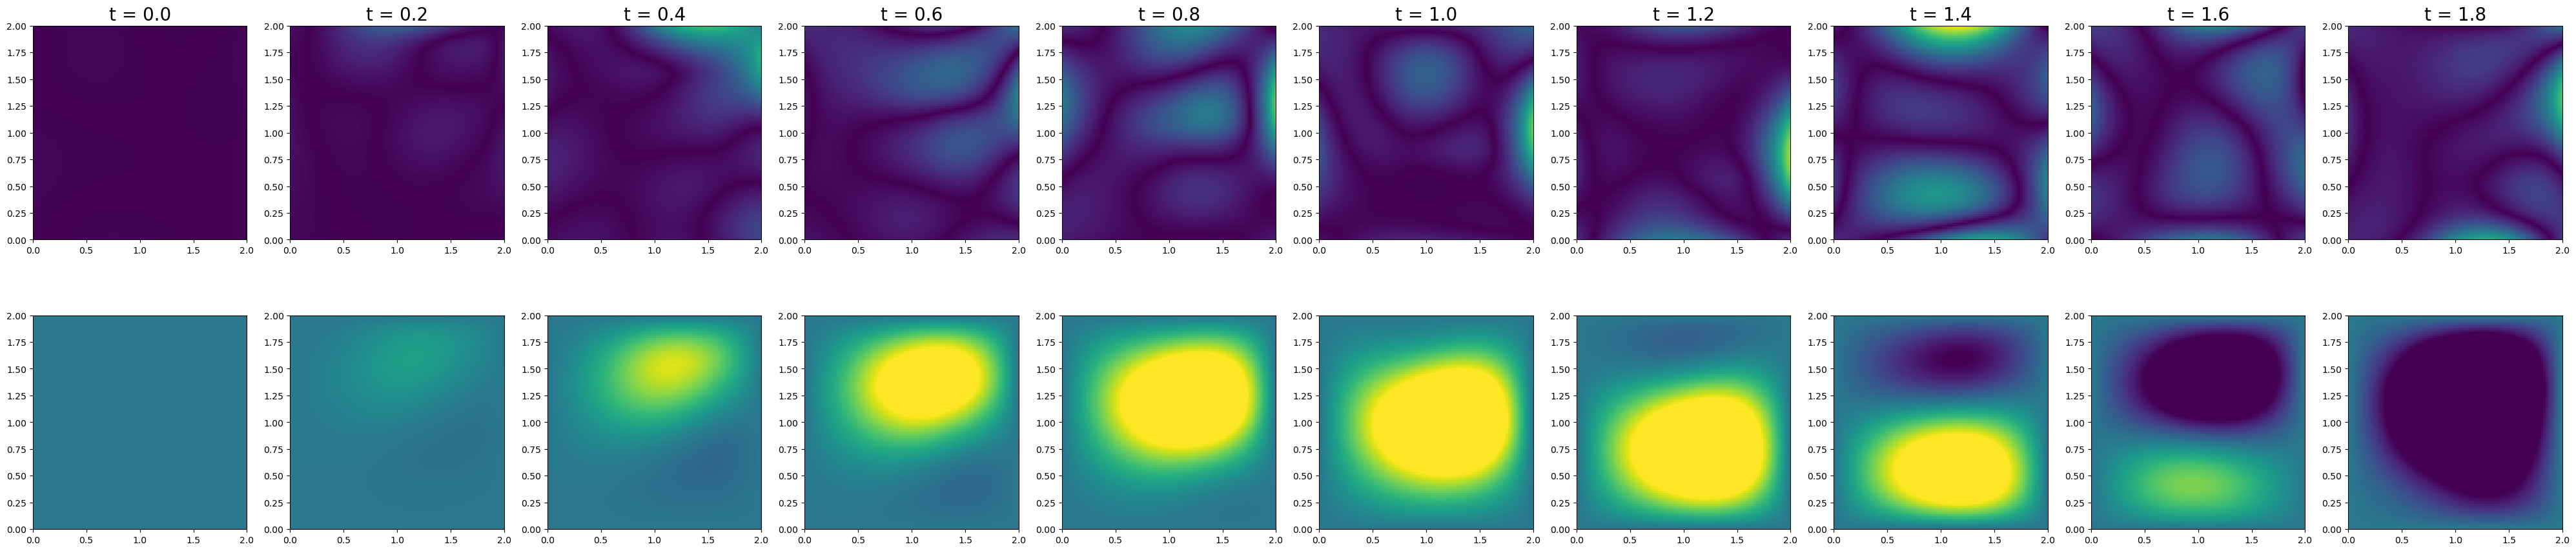

In [19]:
fig, ax = plt.subplots(2,10,figsize=(40,10))
ax = ax.flatten()
#split the ax
ax_1 = ax[:10]
ax_2 = ax[10:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(10),np.linspace(0, 4, len(u_matrix[0,0,:]))):
    
    im = ax_2[i].imshow(u_matrix[:,:,i*5].T, cmap='viridis',extent=[0,2,0,2],vmin = -1, vmax = 1.5)
    #plot the train points. we need to chekck for every t value and then plot the x,y coordinates
    #ax[i].scatter(x_train_u[t_train_u==i*5], y_train_u[t_train_u==i*5], color='red', marker='x', label='training points')
    ax_1[i].imshow(np.abs(mean[i*5,:,:]-u_matrix.T[i*5,:,:]), cmap='viridis',extent=[0,2,0,2],vmin = 0, vmax = 1)

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=20)
    #tight layout
    fig.tight_layout()

In [10]:
X = model.X
import jax.numpy as jnp
def marg_log_likelihood(X, targets, params):
    K = k_uu(X, X, params) + 1e-6*np.eye(len(X))
    L = jnp.linalg.cholesky(K)
    alpha = jnp.linalg.solve(L.T, np.linalg.solve(L, targets))
    
    marg_log_likelihood = -1/2 * jnp.dot(targets.T,alpha) - np.sum(np.log(np.diagonal(L))) - len(X)/2 * np.log(2*np.pi)
    return marg_log_likelihood

from scipy.optimize import minimize
def minimize_log(X,targets):
    targets = targets.ravel()
    def marg_log_likelihood(params):

        K = k_uu(X, X, params)
        L = np.linalg.cholesky(K + 1e-6*np.eye(len(X)))
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, targets))
    
        marg_log_likelihood = 1/2 * np.dot(targets.T,alpha) + np.trace(np.log(L)) + len(X)/2 * np.log(2*np.pi)
        return marg_log_likelihood
    return marg_log_likelihood
theta = minimize(minimize_log(X,model.u_train), x0 = [0.1, 0.1, 0.1, 0.1], 
               bounds=((1e-5, None), (1e-5, None),(1e-5, None),(1e-5, None)),
               method='L-BFGS-B')
print(theta.x)
print(theta.fun)

def posterior_distribution(X, targets,x_test, params ):
    K = k_uu(X, X, params) 
    K_s = k_uu(X, x_test,params)
    K_ss = k_uu(x_test, x_test,params)

    L = jnp.linalg.cholesky(K + 1e-6*np.eye(len(X)))
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, targets))

    f_star = jnp.dot(K_s.T, alpha)
    v = jnp.linalg.solve(L, K_s)
    var_f_star = K_ss - jnp.dot(v.T, v)
    
    return f_star, var_f_star

x = np.linspace(0,2,20).reshape(-1,1)
y = np.linspace(0,2,20).reshape(-1,1)
t = np.linspace(0,4,20).reshape(-1,1)

gx, gy, gt = np.meshgrid(x,y,t)

X_3d = np.c_[gx.ravel(), gy.ravel(), gt.ravel()]
x_test = np.c_[x.ravel(), y.ravel(), t.ravel()]
print(X_3d.shape)

f_star, var_f_star = posterior_distribution(X, model.u_train, X_3d, theta.x)
f_star.shape

f_star = f_star.reshape(20,20,20)
#var_f_star = var_f_star.reshape(20,20,20)



 /var/folders/5m/h4l2_hmn45j_y5q22rrhkpnr0000gn/T/ipykernel_21332/2887015958.py:20: RuntimeWarning:divide by zero encountered in log
 /var/folders/5m/h4l2_hmn45j_y5q22rrhkpnr0000gn/T/ipykernel_21332/2887015958.py:20: RuntimeWarning:invalid value encountered in log


[0.34604319 1.09675816 0.53313263 0.1       ]
-20.52541683509554
(8000, 3)


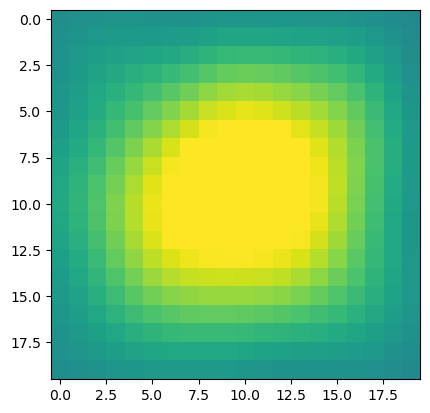

In [11]:
from matplotlib.animation import FuncAnimation
fig, ax  = plt.subplots()
def frame(t):
    ax.clear()
    im = ax.imshow(f_star[:,:,t], cmap='viridis', interpolation='nearest',vmin = -5, vmax = 5)

ani = FuncAnimation(fig, frame, frames=30, repeat=False)

ani.save('test.mp4', writer='ffmpeg', fps=10)